In [1]:
# importing necessary packages
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [5]:
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

In [2]:
PATH2 = "C:/Users/kpunyakoti/Desktop/Future/Flix/Data/traintest/"

In [28]:
# defining some functions
def smape(x, x_):
    """Return the smape value for two arrays."""
    return 100 * np.mean(2 * np.abs(x - x_)/(np.abs(x) + np.abs(x_)))
    
def linear_fit_slope(y):
    """Return the slope of a linear fit to a series."""
    y_pure = y.dropna()
    length = len(y_pure)
    x = np.arange(0, length)
    slope, intercept = np.polyfit(x, y_pure.values, deg=1)
    return slope

def linear_fit_intercept(y):
    """Return the intercept of a linear fit to a series."""
    y_pure = y.dropna()
    length = len(y_pure)
    x = np.arange(0, length)
    slope, intercept = np.polyfit(x, y_pure.values, deg=1)
    return intercept

In [29]:
# importing input datasets
train = pd.read_csv(f'{PATH2}train.csv', parse_dates=True, index_col=['date'])
test = pd.read_csv(f'{PATH2}test.csv', parse_dates=True, index_col=['date'])

# concatenating train and test data frames
test['tickets'] = np.nan
df = pd.concat([train, test.loc[:, ['country_1', 'channel_id', 'tickets']]]).sort_values(by=['country_1', 'channel_id'])

# adding some time-related factors
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofwk'] = df.index.weekday
df['week_num'] = [int(x) for x in np.floor((df.index - pd.to_datetime('2016-12-31')).days/7) + 1]
#df['quarter_block_num'] = (df.index.year - 2013) * 4 + df['quarter']

In [30]:
df.head()

,country_1,channel_id,tickets,month,day,dayofwk,week_num
date,,,,,,,
2017-01-01,1,1,0.0,1,1,6,1
2017-01-02,1,1,0.0,1,2,0,1
2017-01-03,1,1,0.0,1,3,1,1
2017-01-04,1,1,0.0,1,4,2,1
2017-01-05,1,1,0.0,1,5,3,1


In [31]:
# detecting and handling outliers

# finding the slope of a linear fit for sale values grouped by store, item and day of week
lin_slope_df = df.groupby(['country_1', 'channel_id', 'dayofwk'])['tickets'].apply(linear_fit_slope).reset_index()
lin_slope_df.columns = ['country_1', 'channel_id', 'dayofwk', 'lin_slope']
df = df.reset_index().merge(lin_slope_df, how='left', on=['country_1', 'channel_id', 'dayofwk']).set_index('date')

# finding the intercept of a linear fit for sale values grouped by store, item and day of week
lin_intercept_df = df.groupby(['country_1', 'channel_id', 'dayofwk'])['tickets'].apply(linear_fit_intercept).reset_index()
lin_intercept_df.columns = ['country_1', 'channel_id', 'dayofwk', 'lin_intercept']
df = df.reset_index().merge(lin_intercept_df, how='left', on=['country_1', 'channel_id', 'dayofwk']).set_index('date')

# fitting a linear model to the sale values grouped by store, item and day of week (trend)
df['linear_fit'] = (df['week_num'] - 1) * df['lin_slope'] + df['lin_intercept']

# removing the increasing trend from the sale values
df['trend_removed_tickets'] = df['tickets'] - df['linear_fit']

# removing the monthly seasonality from the sale values
differenced_df = df.groupby(['country_1', 'channel_id', 'day'])['trend_removed_tickets'].rolling(window=30, min_periods=30).\
apply(lambda x: x[-1]-x[0]).reset_index()
differenced_df.columns = ['country_1', 'channel_id', 'day', 'date', 'diff']
differenced_df = differenced_df.sort_values(by=['country_1', 'channel_id', 'date'])
df['diff'] = differenced_df['diff'].values

In [32]:
# normalizing the stationary sale values
diff_mean_df = df.groupby(['country_1', 'channel_id', 'day'])['diff'].mean().reset_index()
diff_mean_df.columns = ['country_1', 'channel_id', 'day', 'diff_mean']
df = df.reset_index().merge(diff_mean_df, how='left', on=['country_1', 'channel_id', 'dayofwk']).set_index('date')

diff_std_df = df.groupby(['country_1', 'channel_id', 'dayofwk'])['diff'].std().reset_index()
diff_std_df.columns = ['country_1', 'channel_id', 'dayofwk', 'diff_std']
df = df.reset_index().merge(diff_std_df, how='left', on=['country_1', 'channel_id', 'dayofwk']).set_index('date')

df['norm_diff'] = (df['diff'] - df['diff_mean']) / df['diff_std']

In [33]:
# identifying outliers
df['outlier'] = (abs(df['norm_diff']) > 3) * 1

# handling outliers (interpolation)
corrected_tickets = []
for ind, row in df[df['outlier']==1].iterrows():
    past_week = ind - pd.Timedelta('7 days')
    next_week = ind + pd.Timedelta('7 days')
    country = row['country_1']
    channel = row['channel_id']
    past_week_tickets = df.loc[past_week][(df.loc[past_week]['country_1']==country) & 
    (df.loc[past_week]['channel_id']==channel)]['tickets'].values[0]
    next_week_tickets = df.loc[next_week][(df.loc[next_week]['country_1']==country) & 
    (df.loc[next_week]['channel_id']==channel)]['tickets'].values[0]
    interpolated_tickets = 0.5 * (past_week_tickets + next_week_tickets)
    corrected_tickets.append(interpolated_tickets)
df.loc[df['outlier']==1, 'tickets'] = corrected_tickets

In [34]:
# removing useless columns
df.drop(columns = ['linear_fit',
                   'lin_slope', 
                   'lin_intercept', 
                   'trend_removed_tickets', 
                   'diff', 
                   'diff_mean', 
                   'diff_std', 
                   'norm_diff', 
                   'outlier'], 
                   inplace=True)

In [35]:
df.head()

,country_1,channel_id,tickets,month,day,dayofwk,week_num
date,,,,,,,
2017-01-01,1,1,0.0,1,1,6,1
2017-01-02,1,1,0.0,1,2,0,1
2017-01-03,1,1,0.0,1,3,1,1
2017-01-04,1,1,0.0,1,4,2,1
2017-01-05,1,1,0.0,1,5,3,1


In [36]:
# sorting dataframe
df = df.sort_values(by=['country_1', 'channel_id'])

# building expanding mean sale values for grouped by store, item, (day of week, month, and quarter)
# shift(1) allows to exclude the most recent sale value
for channel in ['dayofwk', 'month']:
    grouped_df = df.groupby(['country_1', 'channel_id', channel])['tickets'].expanding().mean().shift(1).bfill().\
    reset_index()
    grouped_df.columns = ['country_1', 'channel_id', channel,'date', channel + '_ex_avg_sale']
    grouped_df = grouped_df.sort_values(by=['channel_id', 'country_1', 'date'])
    df[channel + '_ex_avg_sale'] = grouped_df[channel + '_ex_avg_sale'].values


In [37]:
# finding store,items whose mean sales value is below the 50% percentile
# (later, the prediction for year 2018 for these store,items will be multiplied by a factor smaller than one)
country_channel_mean_ticket_series = df.groupby(['country_1', 'channel_id'])['tickets'].mean()
ticket_critical_value = country_channel_mean_ticket_series.quantile(0.5)
critical_country_channel_df = country_channel_mean_ticket_series[country_channel_mean_ticket_series < ticket_critical_value].\
reset_index()
critical_country_channel_df.drop(columns=['tickets'], inplace=True)
critical_country_channel_df['critical_country_channel'] = 1
df = df.reset_index().merge(critical_country_channel_df, how='left', on=['country_1', 'channel_id']).\
set_index('date')
df['critical_country_channel'] = df['critical_country_channel'].fillna(0)


In [38]:
# sorting dataframe
#df = df.sort_values(by=['channel_id', 'country_1'])

# defining useful features for lightGBM
used_feats = ['month_ex_avg_sale', 'dow_ex_avg_sale', 'quarter_ex_avg_sale',
              'month', 'dayofwk', 'critical_country_channel', 'tickets']
df = df.loc[:, used_feats]

# defining training and testing data frames
training_df = df.loc['2017']
testing_df = df['2018']

# defining a condition for critical store, items and droping the 'critical_store_item' value
critical_country_channel_mask = testing_df['critical_country_channel']==1
training_df.drop(columns=['critical_country_channel'], inplace=True)
testing_df.drop(columns=['critical_country_channel'], inplace=True)


In [39]:
# developing a lightGBM model, evaluating it and investigating feature importance
X = training_df.loc[:, [col for col in training_df.columns if col not in ['tickets']]]
y = training_df['tickets']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)


In [40]:
# defining the parameters and hyper-parameters. For better result, the hyper-parameters should be 
# tuned carefully.
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'max_depth': 3,
    'metric' : 'mape',
    'learning_rate': 0.1
}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_val,
                early_stopping_rounds=50,
                verbose_eval=2000)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[180]	valid_0's mape: 7.25868


In [41]:
preds = gbm.predict(X_val, num_iteration=gbm.best_iteration)

print('validation smape: ', smape(y_val, preds))
print('validation mae: ', mean_absolute_error(y_val, preds))

validation smape:  186.6954437587059
validation mae:  15.06004257429392


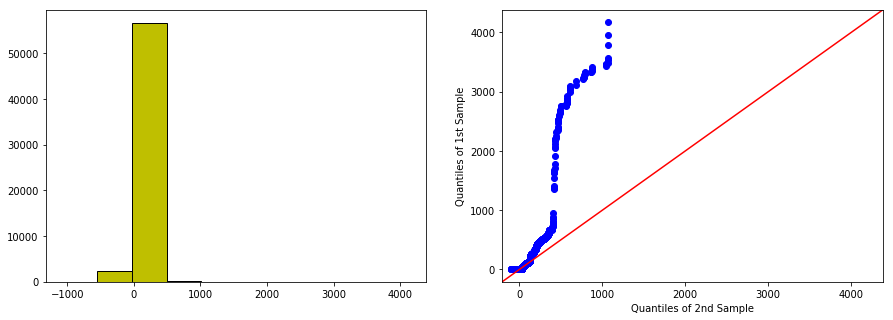

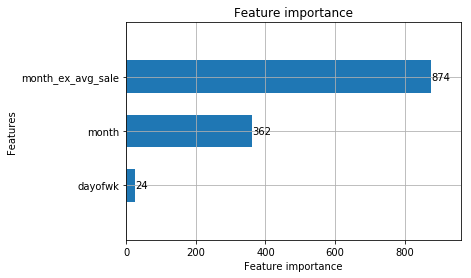

In [42]:
# investigating the distribution of the error
error = y_val.values - preds

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.hist(error, EDGECOLOR='black', color='y')

# comparing the distribution of the predictin and the actual 
sm.qqplot_2samples(y_val.values, preds, line='45', ax=plt.subplot(1, 2, 2))
plt.show()

# exploring the feature importance
lgb.plot_importance(gbm, height=0.6)
plt.show()


In [43]:
# predicting sale values for year 2018
X_train = training_df.loc[:, [col for col in training_df.columns if col not in ['tickets']]].values 
y_train = training_df['tickets'].values
X_test = testing_df.loc[:, [col for col in testing_df.columns if col not in ['tickets']]]
lgb_train = lgb.Dataset(X_train, y_train)

# defining the parameters and hyper-parameters. For better result, the hyper-parameters should be 
# tuned carefully.
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'max_depth': 3,
    'learning_rate': 0.1
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000)
test_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)


In [44]:
testing_df.head()

,month_ex_avg_sale,dow_ex_avg_sale,quarter_ex_avg_sale,month,dayofwk,tickets
date,,,,,,
2018-01-01,0.0,NaN,NaN,1,0,NaN
2018-01-02,0.0,NaN,NaN,1,1,NaN
2018-01-03,0.0,NaN,NaN,1,2,NaN
2018-01-04,0.0,NaN,NaN,1,3,NaN
2018-01-05,0.0,NaN,NaN,1,4,NaN


In [49]:
# adding prediction to testing dataframe
testing_df.loc[:,'tickets'] = test_preds

# for critical store items, the prediction is multplied by a factor slightly smaller than 1 as it 
# apears the model overpredicts them
testing_df.loc[critical_country_channel_mask, 'tickets'] = testing_df.loc[critical_country_channel_mask, 'tickets'] * 0.99

# creating submission
sample_submission = pd.read_csv(f'{PATH2}sample.csv')
sample_submission['tickets'] = np.round(testing_df['tickets'].values)
sample_submission.to_csv(f'{PATH2}check.csv',index=False)
print(sample_submission.head())


       date  country_1  channel_id  tickets
0  1/1/2018          1           1      2.0
1  1/2/2018          1           1      2.0
2  1/3/2018          1           1      2.0
3  1/4/2018          1           1      2.0
4  1/5/2018          1           1      2.0
